# Косенко Никита М24-514
## Лабораторная работа №3, вариант 6

In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Подключаем данные

In [244]:
data = pd.read_csv('data_ml_v3-06.csv')
data.head()
# print(data.shape)

,x,y
0,-0.60604,-1.179300
1,-0.35888,-2.347900
2,-2.05920,1.811500
3,-1.04380,1.678300
4,-1.11560,-0.018185


In [245]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       300 non-null    float64
 1   y       300 non-null    float64
dtypes: float64(2)
memory usage: 4.8 KB


In [246]:
train_data, temp_data = train_test_split(data, test_size=0.4, random_state=42)

# Второе разбиение: 30% validation и 10% test от исходных данных
val_data, test_data = train_test_split(temp_data, test_size=0.25, random_state=42)

print(f"Обучающая выборка: {len(train_data)} записей ({len(train_data)/len(data)*100:.1f}%)")
print(f"Валидационная выборка: {len(val_data)} записей ({len(val_data)/len(data)*100:.1f}%)")
print(f"Тестовая выборка: {len(test_data)} записей ({len(test_data)/len(data)*100:.1f}%)")

Обучающая выборка: 180 записей (60.0%)
Валидационная выборка: 90 записей (30.0%)
Тестовая выборка: 30 записей (10.0%)


Чисто посмотреть, что за данные.

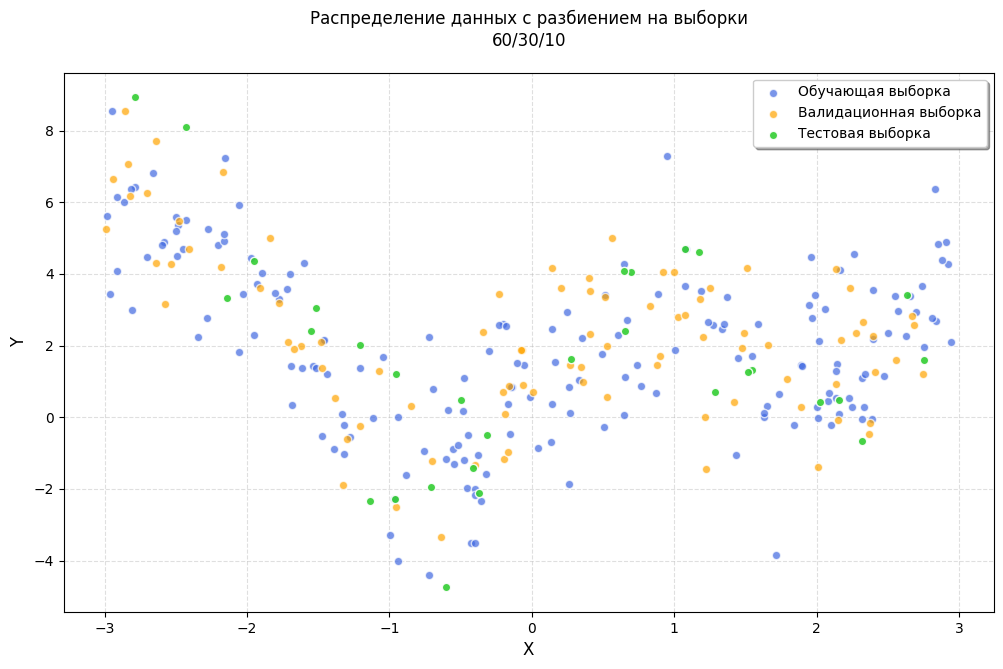

In [247]:
plt.figure(figsize=(12, 7))

# Обучающая выборка
plt.scatter(train_data.iloc[:, 0], train_data.iloc[:, 1],
            c='royalblue', alpha=0.7, edgecolor='w',
            label='Обучающая выборка', zorder=2)

# Валидационная выборка
plt.scatter(val_data.iloc[:, 0], val_data.iloc[:, 1],
            c='orange', alpha=0.7, edgecolor='w',
            label='Валидационная выборка', zorder=2)

# Тестовая выборка
plt.scatter(test_data.iloc[:, 0], test_data.iloc[:, 1],
            c='limegreen', alpha=0.9, edgecolor='w',
            label='Тестовая выборка', zorder=3)

plt.title('Распределение данных с разбиением на выборки\n60/30/10', pad=20)
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.grid(linestyle='--', alpha=0.4)
plt.legend(loc='best', frameon=True, shadow=True)

plt.show()

In [248]:
data.describe()

,x,y
count,300.000000,300.000000
mean,0.067339,1.950503
std,1.726230,2.466536
min,-2.991900,-4.743500
25%,-1.399675,0.307813
50%,0.000024,1.920250
75%,1.598750,3.524375
max,2.947200,8.929800


### Задание 1
Построить регрессограммы для различного числа интервалов группировки:

а) 3

б) 10

в) 50

In [249]:
def fit_bin_regression(train_df, n_bins):
    """Создание модели биновой регрессии"""
    # Создаем интервалы с метками
    bins = pd.cut(train_df.iloc[:, 0], bins=n_bins)
    
    # Сохраняем границы интервалов для предсказаний
    bin_edges = bins.cat.categories.right.to_numpy()
    
    # Рассчитываем средние значения
    bin_means = train_df.groupby(bins, observed=False)[train_df.columns[1]].mean()
    
    return bin_means, bin_edges

In [250]:
def predict_bin_regression(x_values, bin_means, bin_edges):
    """Предсказание значений по биновой модели"""
    # Определяем принадлежность к бинам через границы
    bin_indices = np.digitize(x_values, bin_edges, right=False) - 1
    
    # Ограничиваем индексы в допустимых пределах
    bin_indices = np.clip(bin_indices, 0, len(bin_means)-1)
    
    return bin_means.iloc[bin_indices].values

In [251]:
def plot_regression(data, n_bins, color, title):
    """Визуализация регрессограммы"""
    # Обучаем модель
    bin_means, bin_edges = fit_bin_regression(data, n_bins)
    
    # Создаем сетку для предсказаний
    x_grid = np.linspace(data.iloc[:,0].min(), data.iloc[:,0].max(), 1000)
    y_pred = predict_bin_regression(x_grid, bin_means, bin_edges)
    
    # Визуализация
    plt.scatter(data.iloc[:,0], data.iloc[:,1], 
                alpha=0.3, color='royalblue', label='Данные')
    plt.plot(x_grid, y_pred, color=color, 
             linewidth=2, label='Предсказание')
    
    # Разметка границ бинов
    for edge in bin_edges:
        plt.axvline(edge, color='gray', linestyle='--', alpha=0.5)
    
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(alpha=0.3)
    plt.legend()

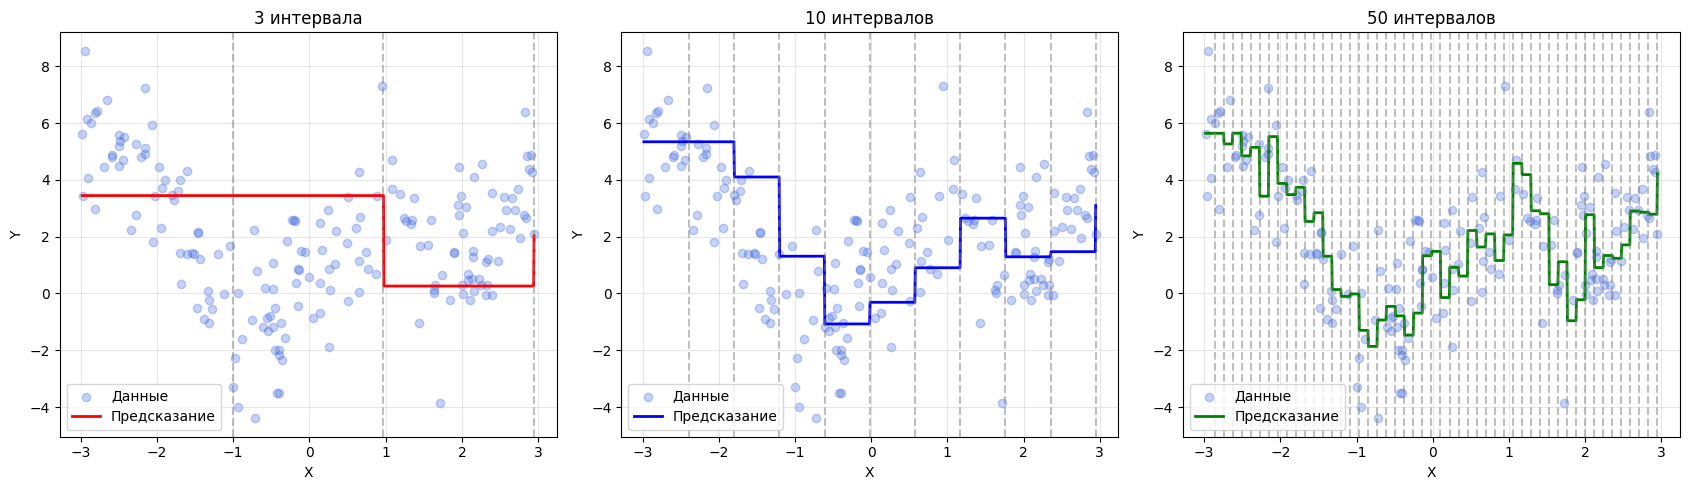

In [252]:
plt.figure(figsize=(17, 5))

# Для 3 интервалов
plt.subplot(1, 3, 1)
plot_regression(train_data, 3, 'red', '3 интервала')

# Для 10 интервалов
plt.subplot(1, 3, 2)
plot_regression(train_data, 10, 'blue', '10 интервалов')

# Для 50 интервалов
plt.subplot(1, 3, 3)
plot_regression(train_data, 50, 'green', '50 интервалов')

plt.tight_layout()
plt.show()

Построить график зависимости MSE непараметрической регрессии на обучающей, 
валидационной и тестовой выборках от числа интервалов группировки. Разбиение на обучающую, валидационную и тестовую выборки – holdout в отношении 60/30/10.

In [253]:
bins_range = [3, 10, 50]  # Диапазон интервалов
results = []

for n_bins in bins_range:
    # Обучение модели
    bin_means, bin_edges = fit_bin_regression(train_data, n_bins)
    
    # Расчет MSE для всех выборок
    for data_name, dataset in [('train', train_data), 
                              ('val', val_data), 
                              ('test', test_data)]:
        x = dataset.iloc[:, 0].values
        y_true = dataset.iloc[:, 1].values
        y_pred = predict_bin_regression(x, bin_means, bin_edges)
        
        mse = mean_squared_error(y_true, y_pred)
        results.append({
            'n_bins': n_bins,
            'dataset': data_name,
            'mse': mse
        })

In [254]:
df_results = pd.DataFrame(results)
pivot_results = df_results.pivot(index='n_bins', columns='dataset', values='mse')

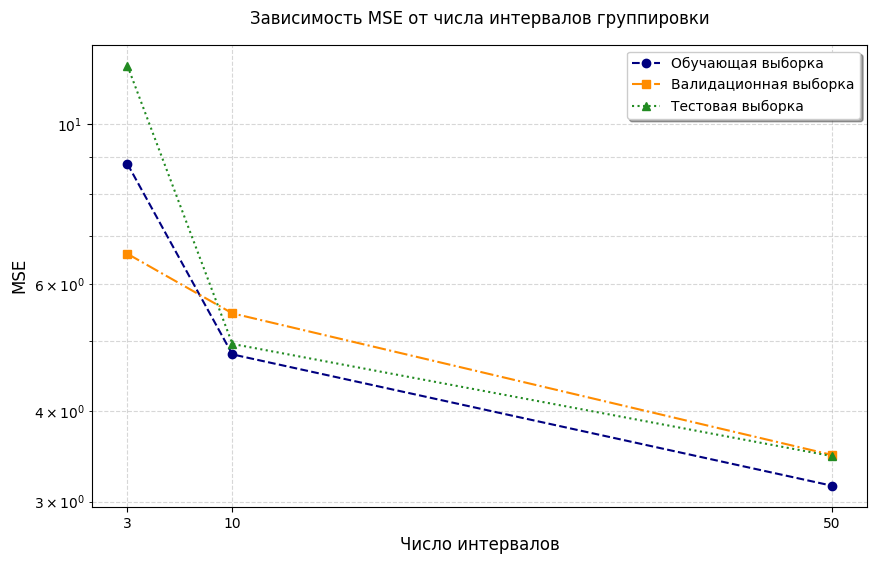

In [255]:
plt.figure(figsize=(10, 6))

# Графики для каждой выборки
plt.plot(pivot_results.index, pivot_results['train'], 
         marker='o', linestyle='--', 
         label='Обучающая выборка', color='navy')

plt.plot(pivot_results.index, pivot_results['val'], 
         marker='s', linestyle='-.', 
         label='Валидационная выборка', color='darkorange')

plt.plot(pivot_results.index, pivot_results['test'], 
         marker='^', linestyle=':', 
         label='Тестовая выборка', color='forestgreen')

# Настройки отображения
plt.title('Зависимость MSE от числа интервалов группировки', pad=15)
plt.xlabel('Число интервалов', fontsize=12)
plt.ylabel('MSE', fontsize=12)
# plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.xticks(bins_range, labels=bins_range)
plt.legend(frameon=True, shadow=True, loc='upper right')

plt.show()

### Задание 2
Построить графики зависимости MSE ядерной регрессии на обучающей, валидационной и тестовой выборках от ширины окна для:

а) прямоугольного окна

б) гауссова окна

в) окна  Епанечникова

г) треугольного окна

Определить оптимальную ширину каждого окна. Оптимальные  значения гиперпараметров обучения определять по значению 
ошибки на валидационной выборке.

### Задание 3
Визуализировать графики ядерной функции регрессии, полученной с использованием каждого вида окна из задания 2.

Ширину окна  задать:

i)  равной  соответствующему  оптимальному  значению,  полученному  в задании 2

ii) значению, меньшему оптимального

iii) значению, большему оптимального 

### Задание 4
Построить  графики зависимости дисперсии и смещения регрессионной модели для 
нескольких фиксированных значений *x* от ширины окна для каждого вида окна из задания 2.

### Задание 5
Построить график зависимости MSE KNN-регрессии от числа ближайших соседей K на 
обучающей и тестовой выборках. Определить оптимальное число ближайших соседей и 
визуализировать  графики  KNN-регрессии для различных значений  K:

а) равному оптимальному

б) меньшего оптимального

в) большего оптимального

Оптимальные  значения гиперпараметров обучения  определять по значению ошибки на валидационной выборке.

### Задание 6
Сделать выводы о влиянии вида и ширины окна на качество ядерной регрессионной модели.